In [32]:
# Cell 2 - imports & basic settings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)


In [33]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\User\fraud


In [34]:
print("Files in this folder:", os.listdir())


Files in this folder: ['.ipynb_checkpoints', 'fraud detection.ipynb', 'LICENSE', 'models', 'PS_20174392719_1491204439457_log.csv', 'README.md', 'Untitled.ipynb', 'Untitled1.ipynb']


In [35]:
DATA_PATH = r"C:\Users\User\Desktop\fraud_detection\data_3000.csv"

import os
import pandas as pd

if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print("✅ Dataset loaded:", DATA_PATH)
    print("Shape:", df.shape)
    display(df.head())
else:
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")


✅ Dataset loaded: C:\Users\User\Desktop\fraud_detection\data_3000.csv
Shape: (3000, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


In [36]:
import pandas as pd

# Path to the dataset CSV file (update as per your local path)
file_path = 'PS_20174392719_1491204439457_log.csv'

chunk_size = 3000

# Create an iterator to read data in chunks
data_iter = pd.read_csv(file_path, chunksize=chunk_size)

# Read first chunk and show info
first_chunk = next(data_iter)
print("First 3000 rows preview:")
print(first_chunk.head())

print("\nData types and missing values in first chunk:")
print(first_chunk.info())
print(first_chunk.isnull().sum())


First 3000 rows preview:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  

Data types and missing values in first chunk:
<class 'pandas.core.frame.DataFra

In [37]:
# Cell 6 - separate numeric and categorical columns (exclude target)
# Start from 'data' created above

# Remove obvious identifiers that shouldn't be used as features
exclude_cols = [target_col, 'nameOrig', 'nameDest', 'orig', 'dest', 'isFlaggedFraud']  # extend if needed
cols = [c for c in data.columns if c not in exclude_cols]

# Numeric columns
numerical_cols = [c for c in cols if np.issubdtype(data[c].dtype, np.number)]
# Categorical columns (object or category)
categorical_cols = [c for c in cols if data[c].dtype == 'object' or str(data[c].dtype).startswith('category')]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'log_amount', 'hour', 'same_party']
Categorical columns: ['type']


In [38]:
# Cell 7 - split
X = data[numerical_cols + categorical_cols]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train positive ratio:", y_train.mean(), "Test positive ratio:", y_test.mean())


Train: (2400, 10) Test: (600, 10)
Train positive ratio: 0.0025 Test positive ratio: 0.0016666666666666668


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop')


In [40]:
# Cell 9 - helper function to run RandomizedSearchCV
def run_search(estimator, param_distributions, X_tr, y_tr, n_iter=20, cv=3, random_state=42):
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', estimator)])
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    search = RandomizedSearchCV(
        pipe, param_distributions, n_iter=n_iter,
        scoring='average_precision', cv=skf, n_jobs=-1, verbose=1, random_state=random_state
    )
    search.fit(X_tr, y_tr)
    return search


In [41]:
# Cell 10 - model definitions & parameter distributions
# Logistic Regression
lr = LogisticRegression(solver='saga', max_iter=5000)
lr_params = {
    'clf__C': np.logspace(-4, 4, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__class_weight': [None, 'balanced']
}

# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10, 30],
    'clf__min_samples_split': [2, 5],
    'clf__class_weight': [None, 'balanced']
}

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# estimate scale_pos_weight to help with class imbalance
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb_params = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.01, 0.1],
    'clf__scale_pos_weight': [1, scale_pos_weight]
}


In [42]:
# Cell 11 - run randomized searches (set n_iter small for quick dev; increase for final)
results = {}

print("Running Logistic Regression search...")
results['lr'] = run_search(lr, lr_params, X_train, y_train, n_iter=10, cv=3)

print("\nRunning Random Forest search...")
results['rf'] = run_search(rf, rf_params, X_train, y_train, n_iter=10, cv=3)

print("\nRunning XGBoost search...")
results['xgb'] = run_search(xgb, xgb_params, X_train, y_train, n_iter=8, cv=3)


Running Logistic Regression search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Running Random Forest search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Running XGBoost search...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


<Figure size 800x600 with 0 Axes>

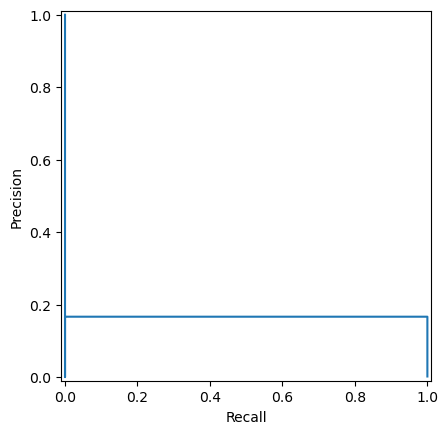

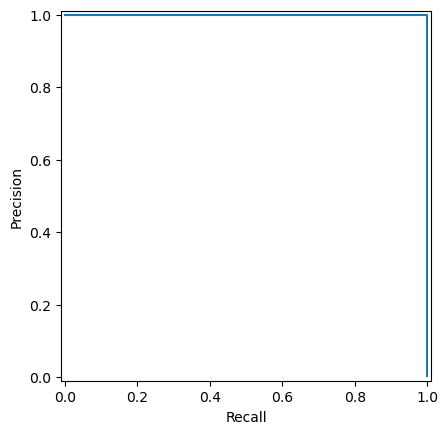

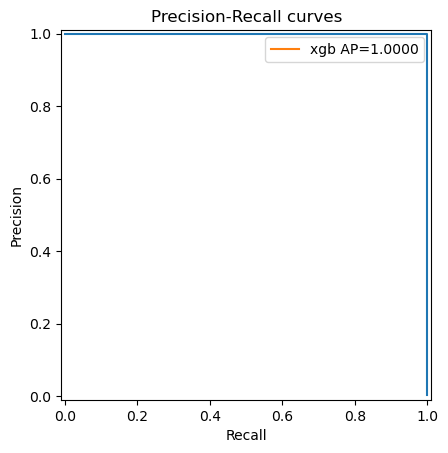

AP scores: {'lr': np.float64(0.16666666666666666), 'rf': np.float64(1.0), 'xgb': np.float64(1.0)}


In [43]:
# Cell 12 - precision-recall curves & AP scores
plt.figure(figsize=(8, 6))

ap_scores = {}
for name, res in results.items():
    best = res.best_estimator_
    # get predicted score for positive class
    try:
        y_scores = best.predict_proba(X_test)[:, 1]
    except Exception:
        y_scores = best.decision_function(X_test)
    ap = average_precision_score(y_test, y_scores)
    ap_scores[name] = ap
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.plot([], [], label=f"{name} AP={ap:.4f}")

plt.title("Precision-Recall curves")
plt.legend()
plt.show()

print("AP scores:", ap_scores)


In [44]:
# Cell 13 - pick best model by AP and show a classification report (default threshold 0.5)
best_key = max(ap_scores, key=ap_scores.get)
best_search = results[best_key]
best_pipeline = best_search.best_estimator_

print("Best model by Average Precision (AP):", best_key, "with AP=", ap_scores[best_key])

# Predict with the pipeline
y_pred = best_pipeline.predict(X_test)
print("\nClassification report (threshold default):")
print(classification_report(y_test, y_pred))


Best model by Average Precision (AP): rf with AP= 1.0

Classification report (threshold default):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       0.00      0.00      0.00         1

    accuracy                           1.00       600
   macro avg       0.50      0.50      0.50       600
weighted avg       1.00      1.00      1.00       600



In [45]:
# Cell 14 - save model
os.makedirs('./models', exist_ok=True)
model_path = f'./models/best_fraud_model_{best_key}.joblib'
joblib.dump(best_pipeline, model_path)
print("Saved model pipeline to:", model_path)


Saved model pipeline to: ./models/best_fraud_model_rf.joblib
